### Gerekli kütüphanelerin import edilmesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import time

import tensorflow as tf
import tensorflow_addons as tfa
from keras.layers import Dense, GlobalMaxPooling2D, Dropout, \
                                    BatchNormalization, Conv2D, \
                                    MaxPooling2D, Concatenate, AveragePooling2D

import matplotlib.pyplot as plt

import os
import numpy as np

import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import PIL
import glob
import pathlib

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

print('TF Version:', tf.__version__)
print('TFA Version:', tfa.__version__)

TF Version: 2.9.2
TFA Version: 0.19.0


In [ ]:
#train klasöründe kaç tane covid19 örnek sayısı
len(os.listdir("/content/drive/MyDrive/Covid_tf.data/chest_xray/train/NORMAL"))

1349

## Verilerin görselleştirilmesi


In [ ]:
train_dir = "/content/drive/MyDrive/Covid_tf.data/chest_xray/train"
test_dir = "/content/drive/MyDrive/Covid_tf.data/chest_xray/test"

print("Train set:\n========================================")
num_covid = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_covid}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3883
NORMAL=1349
Test set:
PNEUMONIA = 270
NORMAL = 130


## tf.data.pipeline kullanarak veri seti oluşturma

In [ ]:
# Her ana klasör kendi için alt sınıf klasörlerine ayrıldığı için
# iki kere /* ekliyoruz. Böylece tüm resimleri almış olacağız.
train_dir_list = train_dir + '/*/*'
test_dir_list = test_dir + '/*/*'



#tf.data kullanacağımızdan dolayı cardinality() fonksiyonunu kullanacağız.
#Bu fonksiyon datasetin boyutunu içeren skalar bir tensör döndürecek.
#.numpy() ile de dönen tensörün sayısal değerini almış oluyoruz.

def data_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

train_dir_list, test_dir_list

('/content/drive/MyDrive/Covid_tf.data/chest_xray/train/*/*',
 '/content/drive/MyDrive/Covid_tf.data/chest_xray/test/*/*')

In [ ]:
# list_files bir tf.data olup, glob patterni eşleşen tüm dosyaları alacaktır.
list_ds_train = tf.data.Dataset.list_files(train_dir_list, 
                                     shuffle = False)

list_ds_test = tf.data.Dataset.list_files(test_dir_list, 
                                     shuffle = False)

list_ds_train = list_ds_train.shuffle(data_size(list_ds_train),
                                     reshuffle_each_iteration = False)

list_ds_test = list_ds_test.shuffle(data_size(list_ds_test),
                                     reshuffle_each_iteration = False)

# Datasetlerden birer tane örnek al.
for files in list_ds_train.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_train\mountain\2174.jpg

for files in list_ds_test.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_test\mountain\24204.jpg
    
# Datasetlerin boyutuna bak.
total_images = data_size(list_ds_train)
print('\nEğitim setinde %d resim var' %(total_images)) # 14034 

total_test = data_size(list_ds_test)
print('\nTest setinde %d resim var' %(total_test)) # 3000

/content/drive/MyDrive/Covid_tf.data/chest_xray/train/PNEUMONIA/VIRUS-7139008-0001.jpeg
/content/drive/MyDrive/Covid_tf.data/chest_xray/test/PNEUMONIA/BACTERIA-8983865-0004.jpeg

Eğitim setinde 5232 resim var

Test setinde 400 resim var


In [ ]:
# Sınıf isimlerini dizinden almak için pathlib kullanıyoruz.
data_dir = pathlib.Path(train_dir)

class_names = [files.name for files in data_dir.glob('*/')]

# Alfabetik olarak sırala.
class_names = np.array(sorted(class_names), dtype = 'object')

print(class_names) #Normal -Pnuemonia

['NORMAL' 'PNEUMONIA']


In [ ]:
# Train datasından validation set oluşturmak için
# take() ve skip() fonksiyonlarını kullanabiliriz.
val_size = int(200)

list_ds_val = list_ds_train.take(val_size)
list_ds_train = list_ds_train.skip(val_size)

print('Train:', data_size(list_ds_train)) # 12631
print('Val:', data_size(list_ds_val)) # 1403
print('Test:', data_size(list_ds_test)) # 3000

# Overlap var mı diye kontrol et.
train = []
for x in list_ds_train:
    train.append(x.numpy().decode('utf-8'))

val = []
for x in list_ds_val:
    val.append(x.numpy().decode('utf-8'))
    
len(set(train).intersection(set(val))) # 0

Train: 5032
Val: 200
Test: 400


0

In [ ]:
tf.__version__

'2.9.2'

TF.Data Pipeline Configuration

In [ ]:
def get_label(files_path):
    # contents tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=string, numpy=
    # array([... b'seg_train', # Son iki string sınıfı ve resmin ismini içeriyor.
    #        b'glacier', b'10.jpg'], dtype=object)>

    contents = tf.strings.split(files_path, os.path.sep)
       
    # class_idx tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=bool, numpy=array([False, False, 
                                        # True, False, False, False])>
    class_idx = contents[-2] == class_names
  
    # Return: tf.where(class_idx)
    # <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>
    # Alternatif olarak tf.argmax(class_idx) kullanabilirdik
    return tf.where(class_idx)[0][0]

def decode_img(image):
    # tf.io.read_file ile okunmuş resimlerin tf.image.decode_jpeg
    # ile decode edilmesi gerekir. Bu sayede resimleri array formatına
    # çevirmiş oluruz. channel=3 diyerek de RGB olduğunu belirtiyoruz.
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def process_path(file_path):
    label = get_label(file_path)
  
    # img :<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\x0\ ...
    # tf.io.read_file içeriği olduğu gibi okur, onun için decode edilmesi gerekir.
    image = tf.io.read_file(file_path)

    # Şimdi ise resimler artık array formatındadır.
    image = decode_img(image)
    return image, label
    

In [ ]:
# num_parallel_calls ile mapping işlemini parallelize etmiş oluyoruz.
# tf.data.AUTOTUNE, tf.data çalışma zamanı sırasında paralellik düzeyine karar verecektir.

train_ds = list_ds_train.map(process_path, 
                             num_parallel_calls=tf.data.AUTOTUNE)

val_ds = list_ds_val.map(process_path, 
                         num_parallel_calls=tf.data.AUTOTUNE)

test_ds = list_ds_test.map(process_path, 
                           num_parallel_calls=tf.data.AUTOTUNE)

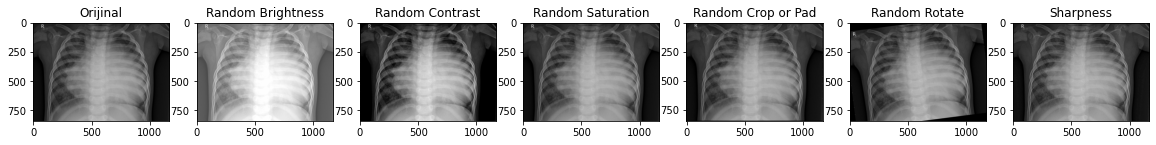

In [ ]:
# tf.image ve tfa.image ile resimleri augment edebilir veya üzerlerinde random
# dönüşümler uygulayabiliriz.

for x, y in train_ds.take(1): # Datasetten 1 tane resim ve label çifti alır.
    seed = (52, 2)
    
    # Burada tf.image ve tfa.image altında olan fonksiyonları göstereceğim.
    # Random dönüşümler için stateless_random_* olanları kullanıyoruz.
    # Farkını aşağıda açıklıyorum.
    
    random_bright = tf.image.stateless_random_brightness(x, max_delta=1.0, 
                                                       seed = seed)

    random_contrast = tf.image.stateless_random_contrast(x, 0.2, 2.0,
                                                       seed = seed)

    random_saturation = tf.image.stateless_random_saturation(x, 0.2, 1.0,
                                                           seed = seed)

    random_crop_or_pad = tf.image.resize_with_crop_or_pad(x, 
                               tf.shape(x).numpy()[0] + 5, 
                               tf.shape(x).numpy()[1] + 5)

    random_rotate = tfa.image.rotate(x, tf.constant(tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.4)))

    sharpness = tfa.image.sharpness(x, 5.1)

    plt.figure(figsize = (20, 12))

    plt.subplot(1, 7, 1)
    plt.imshow(x.numpy() / 255.0)
    plt.title('Orijinal')

    plt.subplot(1, 7, 2)
    plt.imshow(random_bright.numpy() / 255.0)
    plt.title('Random Brightness')

    plt.subplot(1, 7, 3)
    plt.imshow(random_contrast.numpy() / 255.0)
    plt.title('Random Contrast')

    plt.subplot(1, 7, 4)
    plt.imshow(random_saturation.numpy() / 255.0)
    plt.title('Random Saturation')

    plt.subplot(1, 7, 5)
    plt.imshow(random_crop_or_pad.numpy() / 255.0)
    plt.title('Random Crop or Pad')

    plt.subplot(1, 7, 6)
    plt.imshow(random_rotate.numpy() / 255.0)
    plt.title('Random Rotate')

    plt.subplot(1, 7, 7)
    plt.imshow(sharpness.numpy() / 255.0)
    plt.title('Sharpness')

In [ ]:
def resize_and_one_hot(image, label):
    # Resimleri float32'ye cast ediyoruz.
    image = tf.cast(image, tf.float32)
    
    # Resimlerin hepsini 128 x 128 boyutuna getiriyoruz.
    image = tf.image.resize(image, [128, 128])
    
    # Resimleri normalize edip, labelları one hot encoded şeklinde
    # döndürüyoruz.
    return image / 255.0, tf.one_hot(label, 1)

In [ ]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_one_hot(image,label)

    # Dönüşümleri iki gruba ayıracağız.
    transformation_selection = tf.random.uniform([], minval = 0, 
                                                 maxval = 1, 
                                                 dtype = tf.float32)
    
    # İki grubu kendi içinde alt gruplara böleceğiz.
    
    # 1.gruptaki dönüşümleri uygulama ihtimali  
    prob_1 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    
    # 2.gruptaki dönüşümleri uygulama ihtimali        
    prob_2 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    
    # Yani her dönüşümün uygulanmak için %25 şansı var.
    # Her resme sadece bir dönüşüm uygulayacağız.
    image = tf.cond(tf.greater(transformation_selection, 0.5),

                    # tf.cond fonksiyonlarının -callable- olmasını istediği
                    # için lambda yazıyoruz.
                    
                    # Eğer ki transformation_selection > 0.5 ise buraya gelecek.
                    # Eğer prob_1 > 0.5 kontrastı değiştir. Değilse parlaklığı değiştir.
                    lambda: tf.cond(tf.greater(prob_1, 0.5),
                            lambda: tf.image.stateless_random_contrast(image, 0.1, 0.5,
                                                     seed = seed), 
                            lambda: tf.image.stateless_random_brightness(image, max_delta=0.3, 
                                                     seed = seed),
                           ),
                    
                    # Eğer ki transformation_selection < 0.5 ise buraya gelecek.
                    # Eğer prob_2 > 0.5 saturation uygula. Değilse resmi random döndür.
                    lambda: tf.cond(tf.greater(prob_2, 0.5),
                            lambda: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                                           seed = seed),
                            lambda: tfa.image.rotate(image, tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.2))                          
                          )     
                   )

    #   new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #   Eğer ki tf.cond dışında farklı seed kullanıp farklı dönüşümler uygulamak isterseniz
    #   new_seed'i aşağıdaki gibi fonksiyona geçebilirsiniz.
    """
    Örnek: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                              seed = new_seed)
    """
    return image, label

In [ ]:
random_number = tf.random.Generator.from_seed(52222, alg='philox')

# Ana fonksiyonumuz seed alacağı için, bunu başka bir fonksiyonun içine
# koyup, ana fonksiyonumuzu çağırabiliriz. 
def augment_wrapper(x, y):
    seed = random_number.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [ ]:
# Shuffle ve Prefetch'i aşağıda açıklıyorum.

train_ds = (
    train_ds
    .map(augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

# Validasyon ve Test setlerini augment etmiyoruz.
val_ds = (
    val_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# plt.figure(figsize=(20, 20))
# plt.tight_layout()

# # tf.data datasetimizi batchlediğimizden ötürü take(1) bütün batch'i döndürür.
# # Ondan dolayı içeride bir for açıp batch içinde bulunan resimler arasında dönüyoruz.
# for images, labels in train_ds.take(1):
#     for i in range(8):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.show(tf.clip_by_value(images[i], 0, 1).numpy())
#         plt.title(class_names[tf.argmax(labels[i], axis = -1)])
#         plt.axis("off")

In [ ]:
images_per_class = []
class_name = []
for i in os.listdir('/content/drive/MyDrive/Covid_tf.data/chest_xray/train'):
    train_class = os.listdir(os.path.join('/content/drive/MyDrive/Covid_tf.data/chest_xray/train', i))
    images_per_class.append(len(train_class))
    class_name.append(i)
    print('Class: {} = Total Images: {} \n'.format(i, len(train_class)))

Class: NORMAL = Total Images: 1349 

Class: PNEUMONIA = Total Images: 3883 



Model Oluşturma

In [ ]:
input_shape = (128,128,3)

# Input tensor
input_layer = tf.keras.Input(input_shape)

# 2 Convolutions + BN + Swish Aktivasyonu
x = Conv2D(16, 5,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
x = Conv2D(32, 3,kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = tf.nn.silu(x) # swish

x_out_1 = MaxPooling2D((3,3))(x) # Normal MaxPooling

# Concatenate --> 2 Conv Layers & Skip Connection
x = Conv2D(32, 3, padding = 'same')(x_out_1)
x = Conv2D(64, 3, padding = 'same')(x)
x = BatchNormalization()(x)
x = tf.nn.silu(x)
residual_1 = tf.keras.layers.Concatenate()([x,x_out_1])

# Aynı şeyleri yazmak yerine class olarak tanımlayalım.

class SkipConnectionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        # Sınıf değişkenlerini setup ediyoruz.
        super(SkipConnectionLayer, self).__init__()
        self.units = units

    def build(self, units):
        # Layerları ekliyoruz.
        self.conv = Conv2D(self.units, 
                                kernel_size= (3, 3),
                                 padding = 'same')

        self.conv2 = Conv2D(self.units, 
                               kernel_size= (3, 3),
                               padding = 'same')
        self.bn = BatchNormalization()

    def call(self, inputs, training = False):
        # Forward propagation burada oluyor.
        
        # Dropout, BatchNorm gibi layerların davranışları train ve test
        # zamanında farklıdır. Modelden prediction alırken bu layerların
        # aktif olmasını istemeyiz. Training, bu davranışı kontrol ediyor.
        x = self.conv(inputs)
        x = self.conv2(x)

        x = self.bn(x, training = training)
        x = tf.nn.silu(x)
        return Concatenate()([x, inputs])
    
    # get_config'i override ediyoruz, böylece TF modeli
    # kaydederken veya yüklerken sorun yaşamayacak.
    # Kaynak koduna bakıp daha fazla bilgi edinmek isterseniz:
    # https://github.com/tensorflow/tensorflow/blob/cdf2c541c3dd3fb6d03cce4d23fc6c548bc9017c/tensorflow/python/keras/engine/base_layer.py#L539-L594
    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)     


# SkipConnection layerlarını subclass olarak ifade ettik.

x = SkipConnectionLayer(64)(residual_1)
x = SkipConnectionLayer(128)(x)
x = SkipConnectionLayer(256)(x)

x = MaxPooling2D((3,3))(x)

x = Conv2D(512, (3,3), padding = 'same',kernel_regularizer= tf.keras.regularizers.l2(0.01),
                                   name = 'last_conv_layer')(x)
x = tf.nn.silu(x)

# Average Pooling
x = AveragePooling2D((2,2), name = 'avg_pool')(x)

# Final layer
x = GlobalMaxPooling2D()(x)
x = Dense(1, activation = 'sigmoid', name = 'last_dense')(x)
# 6 class ve multi-class classification olduğu için
# softmax aktivasyonu kullandık.

model = tf.keras.Model(inputs = input_layer, 
                       outputs = x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 124, 124, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 122, 122, 32  4640        ['conv2d[0][0]']                 
                                )                                                             


Modeli Compile etme

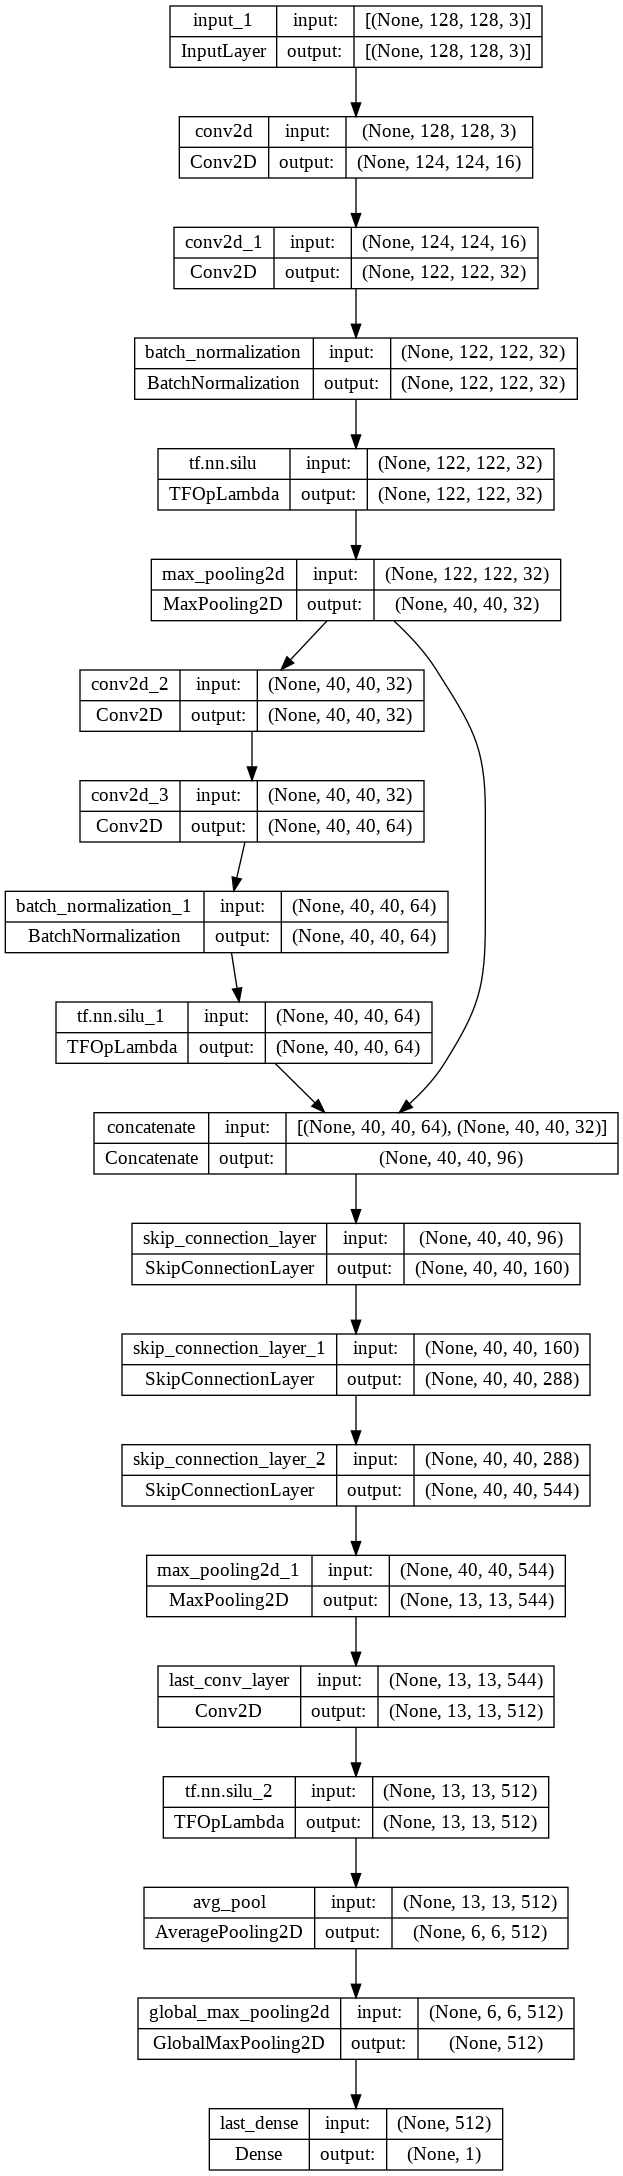

In [ ]:
#modeli görselleştirme (visualization)

tf.keras.utils.plot_model(model,"model.png",show_shapes=True)

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],)

Modeli Eğitme

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,)

lr_schedule = ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [ ]:
batch_size=32


# For model.fit

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4,
    steps_per_epoch=40,
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

Epoch 1/10
40/40 [==============================] - 911s 15s/step - loss: 5.9752 - accuracy: 0.6883 - val_loss: 3.9260 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - 570s 14s/step - loss: 3.0561 - accuracy: 0.8121 - val_loss: 2.9808 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 3/10
40/40 [==============================] - 588s 15s/step - loss: 1.9743 - accuracy: 0.8445 - val_loss: 1.7960 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 4/10
38/40 [===========================>..] - ETA: 27s - loss: 1.4113 - accuracy: 0.8618

40/40 [==============================] - 555s 14s/step - loss: 1.4113 - accuracy: 0.8618 - val_loss: 1.6022 - val_accuracy: 0.5300 - lr: 0.0010
